# SMPT: Experimental Results

In this notebook, we report on some experimental results obtained with SMPT, our prototype implementation of an SMT-based model-checker with reduction equations.

### Setup Analysis

Import librairies

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Path to data

In [2]:
path_data = 'data/merged/'

Settings

In [3]:
TIMEOUT = 60
FIGSIZE = (15,5)

## Load Data

Data frame corresponding to the reduction data.

In [4]:
# Read 'reduction.csv'
df_reduction = pd.read_csv(path_data + 'reduction.csv')
df_reduction

,MODEL,TIME,RATIO,ANALYSIS
0,AirplaneLD-PT-0010,0.353537,88,False
1,AirplaneLD-PT-0020,0.181456,93,False
2,AirplaneLD-PT-0050,0.220841,97,False
3,AirplaneLD-PT-0100,0.241316,98,False
4,AirplaneLD-PT-0200,0.399222,99,False
...,...,...,...,...
1003,ViralEpidemic-PT-S08D1C2A02,0.192629,9,False
1004,ViralEpidemic-PT-S08D1C2A04,869.053407,9,False
1005,ViralEpidemic-PT-S16D2C4A01,0.383970,5,False
1006,ViralEpidemic-PT-S16D2C4A02,8.478698,5,False


Data frame corresponding to the ReachabilityCardinality properties.

In [5]:
# Read 'ReachabilityCardinality.csv'
df_RC = pd.read_csv(path_data + 'RC.csv')
df_RC

,MODEL,PROPERTY,MONOTONE,TIME_WITH_REDUCTION,METHOD_WITH_REDUCTION,CORRECTNESS_WITH_REDUCTION,TIME_WITHOUT_REDUCTION,METHOD_WITHOUT_REDUCTION,CORRECTNESS_WITHOUT_REDUCTION
0,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-00,False,NaN,None,None,NaN,None,None
1,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-01,False,NaN,None,None,NaN,None,None
2,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-02,False,NaN,None,None,NaN,None,None
3,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-03,True,1.317632,IC3,True,NaN,None,None
4,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-04,True,6.905457,IC3,True,NaN,None,None
...,...,...,...,...,...,...,...,...,...
91,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityCardinality-11,False,NaN,None,None,NaN,None,None
92,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityCardinality-12,True,13.048807,IC3,True,NaN,None,None
93,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityCardinality-13,False,NaN,None,None,NaN,None,None
94,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityCardinality-14,False,NaN,None,None,NaN,None,None


Data frame corresponding to the ReachabilityFireability properties.

In [6]:
# Read 'ReachabilityFireability.csv'
df_RF = pd.read_csv(path_data + 'RF.csv')
df_RF

,MODEL,PROPERTY,MONOTONE,TIME_WITH_REDUCTION,METHOD_WITH_REDUCTION,CORRECTNESS_WITH_REDUCTION,TIME_WITHOUT_REDUCTION,METHOD_WITHOUT_REDUCTION,CORRECTNESS_WITHOUT_REDUCTION
0,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityFireability-00,True,0.026019,BMC,True,15.349598,BMC,True
1,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityFireability-01,False,0.017523,BMC,True,3.111217,BMC,True
2,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityFireability-02,False,NaN,None,None,NaN,None,None
3,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityFireability-03,False,0.014600,BMC,True,0.170743,BMC,True
4,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityFireability-04,True,0.030978,BMC,True,0.539939,BMC,True
...,...,...,...,...,...,...,...,...,...
82,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityFireability-02,True,7.334224,BMC,True,NaN,None,None
83,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityFireability-03,False,0.976014,BMC,True,NaN,None,None
84,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityFireability-04,True,2.710290,BMC,True,NaN,None,None
85,AirplaneLD-PT-0500,AirplaneLD-PT-0500-ReachabilityFireability-05,False,NaN,None,None,NaN,None,None


Data frame corresponding to the ReachabilityDeadlock properties.

In [7]:
# Read 'ReachabilityDeadlock.csv'
df_RD = pd.read_csv(path_data + 'RD.csv')
df_RD

,MODEL,PROPERTY,MONOTONE,TIME_WITH_REDUCTION,METHOD_WITH_REDUCTION,CORRECTNESS_WITH_REDUCTION,TIME_WITHOUT_REDUCTION,METHOD_WITHOUT_REDUCTION,CORRECTNESS_WITHOUT_REDUCTION
0,AirplaneLD-PT-0010,ReachabilityDeadlock,False,0.021472,BMC,True,1.778207,BMC,True
1,AirplaneLD-PT-0020,ReachabilityDeadlock,False,0.032518,BMC,True,2.765876,BMC,True
2,AirplaneLD-PT-0050,ReachabilityDeadlock,False,0.059696,BMC,True,10.599967,BMC,True
3,AirplaneLD-PT-0100,ReachabilityDeadlock,False,0.121515,BMC,True,33.059684,BMC,True
4,AirplaneLD-PT-0200,ReachabilityDeadlock,False,0.303116,BMC,True,NaN,None,None


Concatenate properties data frames into one. 

In [8]:
# Concatenate 'ReachabilityCardinality', ''ReachabilityFireability' and 'ReachabilityDeadlock' 
df_properties = pd.concat([df_RC, df_RF, df_RD])

# Convert correctness to str
df_properties = df_properties.astype({'CORRECTNESS_WITH_REDUCTION': 'str', 'CORRECTNESS_WITHOUT_REDUCTION': 'str'})

df_properties

,MODEL,PROPERTY,MONOTONE,TIME_WITH_REDUCTION,METHOD_WITH_REDUCTION,CORRECTNESS_WITH_REDUCTION,TIME_WITHOUT_REDUCTION,METHOD_WITHOUT_REDUCTION,CORRECTNESS_WITHOUT_REDUCTION
0,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-00,False,NaN,None,None,NaN,None,None
1,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-01,False,NaN,None,None,NaN,None,None
2,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-02,False,NaN,None,None,NaN,None,None
3,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-03,True,1.317632,IC3,True,NaN,None,None
4,AirplaneLD-PT-0010,AirplaneLD-PT-0010-ReachabilityCardinality-04,True,6.905457,IC3,True,NaN,None,None
...,...,...,...,...,...,...,...,...,...
0,AirplaneLD-PT-0010,ReachabilityDeadlock,False,0.021472,BMC,True,1.778207,BMC,True
1,AirplaneLD-PT-0020,ReachabilityDeadlock,False,0.032518,BMC,True,2.765876,BMC,True
2,AirplaneLD-PT-0050,ReachabilityDeadlock,False,0.059696,BMC,True,10.599967,BMC,True
3,AirplaneLD-PT-0100,ReachabilityDeadlock,False,0.121515,BMC,True,33.059684,BMC,True


## Tool Confidence rate

### Reliability

Reliability with reduction.

In [9]:
reliability_with_reduction = df_properties.query('CORRECTNESS_WITH_REDUCTION == "False"').shape[0] / df_properties.shape[0] * 100
reliability_with_reduction

0.0

Reliability without reduction.

In [10]:
reliability_without_reduction = df_properties.query('CORRECTNESS_WITHOUT_REDUCTION == "False"').shape[0] / df_properties.shape[0] * 100
reliability_without_reduction

0.0

### Correct Values

Correct values with reduction.

In [11]:
correct_values_with_reduction = df_properties.query('CORRECTNESS_WITH_REDUCTION == "True"').shape[0]
correct_values_with_reduction

106

Correct values without reduction.

In [12]:
correct_values_without_reduction = df_properties.query('CORRECTNESS_WITHOUT_REDUCTION == "True"').shape[0]
correct_values_without_reduction

75

### Summary Table

In [13]:
summary = {'Reliability': [reliability_with_reduction, reliability_without_reduction], 'Correct Values': [correct_values_with_reduction, correct_values_without_reduction]}
pd.DataFrame(data=summary, index=['With reduction', 'Without reduction'])

,Reliability,Correct Values
With reduction,0.0,106
Without reduction,0.0,75


## Analysis

Analysis of the approach.

### Reduction Ratio 

Reduction ratio among instances.

In [14]:
# Count instances with same reduction ratio
ratio_frequency = df_reduction['RATIO'].value_counts().sort_index(ascending=False)

# Cumulative data frame
df_ratio_frequency = pd.DataFrame({'MODELS': ratio_frequency.values}).cumsum()
df_ratio_frequency['RATIO'] = ratio_frequency.index

# Add row '0'
df_first_row = pd.DataFrame([{'MODELS': 1, 'RATIO': df_ratio_frequency['RATIO'][0]}])
df_ratio_frequency = pd.concat([df_first_row, df_ratio_frequency])

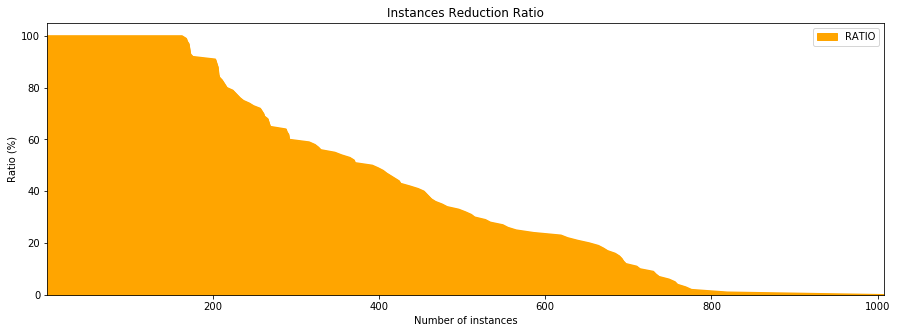

In [15]:
# Draw instances reduction ratio
df_ratio_frequency.plot.area(x='MODELS', color='orange', figsize=(15,5))
plt.xlabel('Number of instances')
plt.ylabel('Ratio (%)')
plt.title("Instances Reduction Ratio")
plt.show()

### Properties Processed in a Limited Time: With vs Without Reduction

Comparaison of the number of processed properties in a limited time between with and without reduction.

In [16]:
def properties_processed_in_limited_time(reduction):
    """ Plot the number of properties processed with a timelimit with or without reduction.
    """
    df = df_properties[['TIME_{}_REDUCTION'.format(reduction)]].query('TIME_{}_REDUCTION == TIME_{}_REDUCTION'.format(reduction, reduction)).sort_values('TIME_{}_REDUCTION'.format(reduction)).reset_index(drop=True)

    def time_query(x):
        return df[['TIME_{}_REDUCTION'.format(reduction)]].query('TIME_{}_REDUCTION <= {}'.format(reduction, x)).shape[0]
    
    y_axis = np.arange(TIMEOUT + 1)
    x_axis = [time_query(x) for x in y_axis]

    if reduction == 'WITH':
        color, label = 'blue', 'With reducion'
    else:
        color, label = 'red', 'Without reduction'
    
    plt.plot(x_axis, y_axis, color=color, label=label)

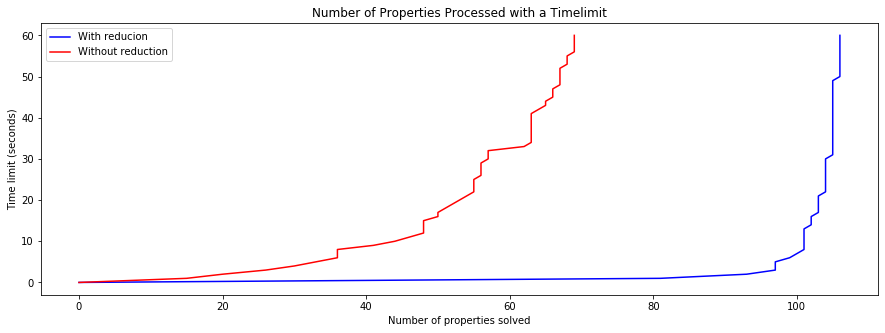

In [17]:
plt.figure(figsize=FIGSIZE)

properties_processed_in_limited_time('WITH')
properties_processed_in_limited_time('WITHOUT')

plt.legend()
plt.xlabel('Number of properties solved')
plt.ylabel('Time limit (seconds)')
plt.title("Number of Properties Processed with a Timelimit")
plt.show()

### Properties Processed in a Limited Time: BMC vs IC3

Comparaison of the number of processed properties in a limited time between BMC and IC3.

In [18]:
def properties_processed_limited_time_with_fixed_method(reduction, method):
    """ Plot the number of properties processed with a timelimit using BMC or IC3, with or without reduction.
    """
    df = df_properties.query('TIME_{}_REDUCTION == TIME_{}_REDUCTION and METHOD_{}_REDUCTION == "{}"'.format(reduction, reduction, reduction, method))
    df = df[['TIME_{}_REDUCTION'.format(reduction)]].sort_values('TIME_{}_REDUCTION'.format(reduction)).reset_index(drop=True)

    def time_query(x):
        return df[['TIME_{}_REDUCTION'.format(reduction)]].query('TIME_{}_REDUCTION <= {}'.format(reduction, x)).shape[0]
     
    y_axis = np.arange(61)
    x_axis = [time_query(x) for x in y_axis]

    if reduction == 'WITH':
        color = 'blue'
    else:
        color = 'red'
        
    if method == 'BMC':
        linestyle = '-'
    else:
        linestyle = '--'
    
    label = '{} {} reduction'.format(method, reduction.lower())
    
    plt.plot(x_axis, y_axis, label=label, color=color, linestyle=linestyle)

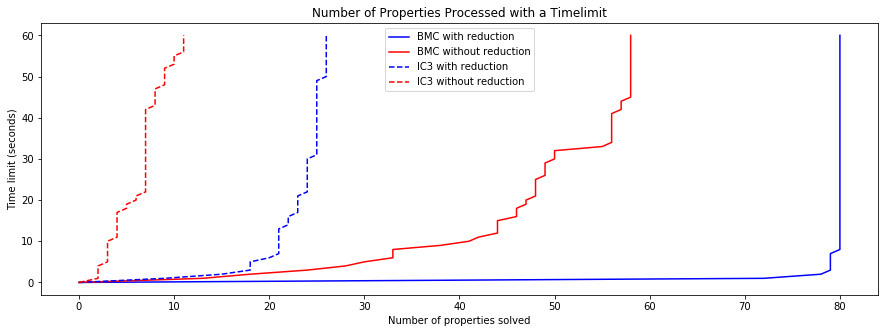

In [19]:
plt.figure(figsize=FIGSIZE)

properties_processed_limited_time_with_fixed_method('WITH', 'BMC')
properties_processed_limited_time_with_fixed_method('WITHOUT', 'BMC')
properties_processed_limited_time_with_fixed_method('WITH', 'IC3')
properties_processed_limited_time_with_fixed_method('WITHOUT', 'IC3')

plt.legend()
plt.xlabel('Number of properties solved')
plt.ylabel('Time limit (seconds)')
plt.title("Number of Properties Processed with a Timelimit")
plt.show()